In [132]:
# Step 1: Install Required Libraries
!pip install keras-tuner

In [133]:
# Step 2: Import Dependencies
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import os

In [134]:
# Mount Google Drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/"

!ls "/content/drive/My Drive/diabetes_dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'assignment _2024-05-06 21:03:25.642552.pdf'
'Colab Notebooks'
 CV_.docx
 diabetes_dataset
 health_consent_form_.pdf
 IMG_1098.jpeg
 IMG_1099.jpeg
'IMG_1100 (1).jpeg'
 IMG_1100.jpeg
'IMG_1101 (1).jpeg'
 IMG_1101.jpeg
 IMG_1102.jpeg
 IMG_1103.jpeg
'OTOBO VICTOR IYAYE, Assignment 2.pdf'
'Otobo, Victor Iyaye.docx'
 Tc.pdf
'Term 1.rar'
 Untitled.pdf
'Victor Iyeya Otobo 14634365 EECT044 1_2024 Offer Letter.docx.pdf'
data-01  data-08  data-15  data-22  data-29  data-36  data-43  data-50	data-57  data-64
data-02  data-09  data-16  data-23  data-30  data-37  data-44  data-51	data-58  data-65
data-03  data-10  data-17  data-24  data-31  data-38  data-45  data-52	data-59  data-66
data-04  data-11  data-18  data-25  data-32  data-39  data-46  data-53	data-60  data-67
data-05  data-12  data-19  data-26  data-33  data-40  data-47  data-54	data-61  data-68
data-06  data-13

In [135]:
# Set path to the folder containing your dataset
data_dir = "/content/drive/My Drive/diabetes_dataset"

# Get all file names that match "data-XX"
data_files = [f for f in os.listdir(data_dir) if f.startswith("data-")]

# Initialize an empty list to store DataFrames
df_list = []

# Read each file and append it to the list
for file in data_files:
    file_path = os.path.join(data_dir, file)

    try:
        # Read the file with tab delimiter
        df = pd.read_csv(file_path, delimiter="\t", header=None, names=["Date", "Time", "Glucose_Level", "Other_Value"])

        # Add a Patient_ID column to track the source file
        df["Patient_ID"] = file

        # Append the DataFrame to the list
        df_list.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")


final_df = pd.concat(df_list, ignore_index=True)
final_df["Datetime"] = pd.to_datetime(final_df["Date"] + " " + final_df["Time"], errors="coerce")
final_df.drop(columns=["Date", "Time"], inplace=True)
final_df.dropna(subset=["Datetime"], inplace=True)
final_df = final_df[final_df["Glucose_Level"] > 0]
final_df.sort_values(by="Datetime", inplace=True)
final_df.reset_index(drop=True, inplace=True)

# Combine all data into a single DataFrame
final_df = pd.concat(df_list, ignore_index=True)

# Display the first few rows
print(final_df.head())

         Date   Time  Glucose_Level Other_Value Patient_ID
0  04-21-1991   9:09             58         100    data-01
1  04-21-1991   9:09             33           9    data-01
2  04-21-1991   9:09             34          13    data-01
3  04-21-1991  17:08             62         119    data-01
4  04-21-1991  17:08             33           7    data-01


<ipython-input-135-9d969392e782>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.sort_values(by="Datetime", inplace=True)


In [136]:
# Step 1: Dataset Analysis
print("Basic Info:")
print(final_df.info())
print("\nMissing Values:")
print(final_df.isnull().sum())
print("\nSummary Statistics:")
print(final_df.describe())


print(final_df.columns)  # Show column names

# Assign Proper Column Names
final_df.columns = ["Date", "Time", "Glucose_Level", "Other_Value", "Patient_ID"]
print(final_df["Glucose_Level"].value_counts())


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29330 entries, 0 to 29329
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           29297 non-null  object
 1   Time           29330 non-null  object
 2   Glucose_Level  29330 non-null  int64 
 3   Other_Value    29297 non-null  object
 4   Patient_ID     29330 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB
None

Missing Values:
Date             33
Time              0
Glucose_Level     0
Other_Value      33
Patient_ID        0
dtype: int64

Summary Statistics:
       Glucose_Level
count   29330.000000
mean       46.428606
std        13.453219
min         0.000000
25%        33.000000
50%        48.000000
75%        60.000000
max        72.000000
Index(['Date', 'Time', 'Glucose_Level', 'Other_Value', 'Patient_ID'], dtype='object')
Glucose_Level
33    9518
34    3830
58    3518
62    3160
60    2771
48    1883
35    1053
57     

In [137]:
# Step 2: Data Cleaning

# Convert 'Date' and 'Time' into a single Datetime column
final_df["Datetime"] = pd.to_datetime(final_df["Date"] + " " + final_df["Time"], errors="coerce")

# Drop the original 'Date' and 'Time' columns
final_df.drop(columns=["Date", "Time"], inplace=True)

# Convert 'Other_Value' to numeric, forcing errors to NaN
final_df["Other_Value"] = pd.to_numeric(final_df["Other_Value"], errors="coerce")

# Handle missing values: Remove rows where 'Datetime' is NaT
final_df = final_df.dropna(subset=["Datetime"])

# Drop rows with missing values in 'Other_Value' (only 8 rows affected)
final_df = final_df.dropna(subset=["Other_Value"])

# Replace or drop invalid Glucose_Level (e.g., 0 values)
final_df = final_df[final_df["Glucose_Level"] > 0]

# Sort by Datetime
final_df.sort_values(by="Datetime", inplace=True)

# Reset index
final_df.reset_index(drop=True, inplace=True)

# Display cleaned dataset info
print(final_df.info())
print(final_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Glucose_Level  29244 non-null  int64         
 1   Other_Value    29244 non-null  float64       
 2   Patient_ID     29244 non-null  object        
 3   Datetime       29244 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 914.0+ KB
None
   Glucose_Level  Other_Value Patient_ID            Datetime
0             58        134.0    data-68 1988-03-27 08:00:00
1             34         20.0    data-68 1988-03-27 08:00:00
2             60        158.0    data-68 1988-03-27 12:00:00
3             62        258.0    data-68 1988-03-27 18:00:00
4             34         20.0    data-68 1988-03-28 08:00:00


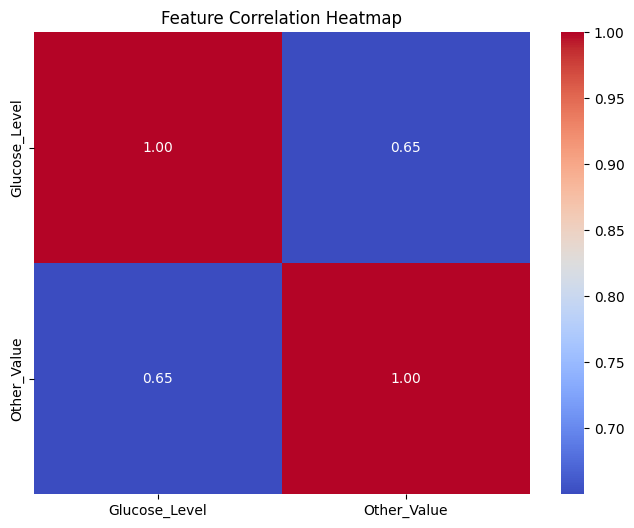

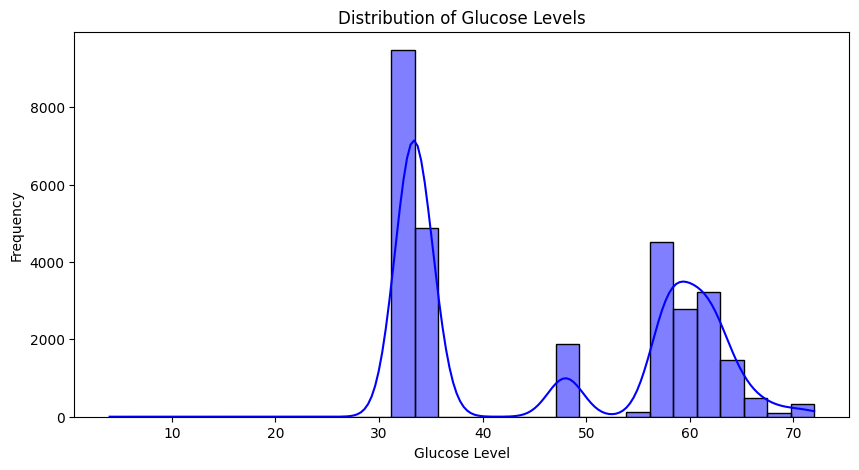

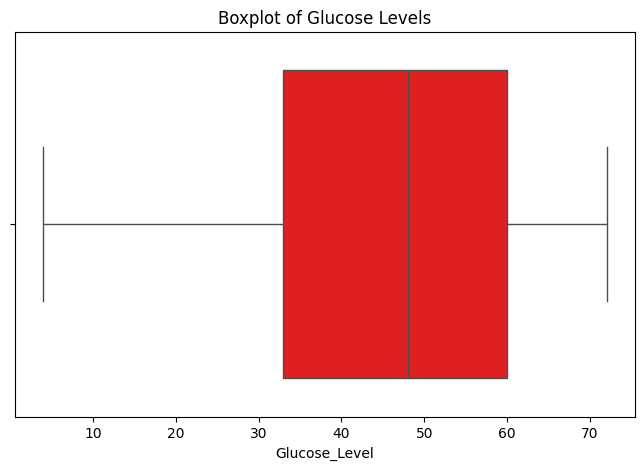

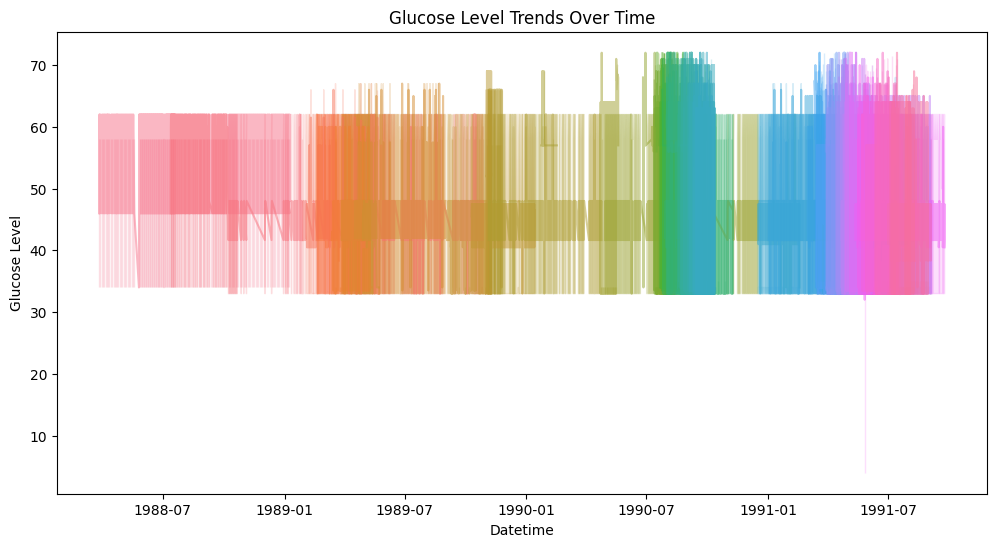

In [138]:
# Step 3: Exploratory Data Analysis (EDA)

# Correlation Analysis
numeric_df = final_df.select_dtypes(include=np.number)  # Select only numeric columns

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")  # Use numeric_df
plt.title("Feature Correlation Heatmap")
plt.show()

# Glucose Level Distribution
plt.figure(figsize=(10, 5))
sns.histplot(final_df["Glucose_Level"], bins=30, kde=True, color='blue')
plt.title("Distribution of Glucose Levels")
plt.xlabel("Glucose Level")
plt.ylabel("Frequency")
plt.show()

# Outlier Detection using Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=final_df["Glucose_Level"], color='red')
plt.title("Boxplot of Glucose Levels")
plt.show()

# Trend Analysis: Glucose Levels Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(x=final_df["Datetime"], y=final_df["Glucose_Level"], hue=final_df["Patient_ID"], alpha=0.5, legend=False)
plt.title("Glucose Level Trends Over Time")
plt.xlabel("Datetime")
plt.ylabel("Glucose Level")
plt.show()

In [139]:
# Step 4: Feature Engineering

final_df["Hour"] = final_df["Datetime"].dt.hour
final_df["Day_of_Week"] = final_df["Datetime"].dt.dayofweek
final_df["Month"] = final_df["Datetime"].dt.month

# Creating Time-Based Features
final_df["Is_Morning"] = (final_df["Hour"] < 12).astype(int)
final_df["Is_Afternoon"] = ((final_df["Hour"] >= 12) & (final_df["Hour"] < 18)).astype(int)
final_df["Is_Evening"] = (final_df["Hour"] >= 18).astype(int)

# Rolling Statistics - Moving Average and Standard Deviation
final_df["Glucose_RollingMean_3"] = final_df["Glucose_Level"].rolling(window=3, min_periods=1).mean()
final_df["Glucose_RollingStd_3"] = final_df["Glucose_Level"].rolling(window=3, min_periods=1).std()

# Lag Features - Previous Glucose Levels
final_df["Glucose_Lag_1"] = final_df["Glucose_Level"].shift(1)
final_df["Glucose_Lag_2"] = final_df["Glucose_Level"].shift(2)

# Rate of Change in Glucose Levels
final_df["Glucose_Change_Rate"] = final_df["Glucose_Level"].diff()

# Handle missing values in newly created features
final_df.fillna(method='bfill', inplace=True)


<ipython-input-139-f4a27b66a20c>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df.fillna(method='bfill', inplace=True)


In [140]:
# Step 5: Data Preprocessing for Modeling
# Encoding Categorical Features to numerical features
label_encoder = LabelEncoder()
final_df["Patient_ID"] = label_encoder.fit_transform(final_df["Patient_ID"])

# Feature Scaling
scaler = StandardScaler()
scaled_features = ["Glucose_Level", "Other_Value", "Glucose_RollingMean_3", "Glucose_RollingStd_3", "Glucose_Lag_1", "Glucose_Lag_2"]
final_df[scaled_features] = scaler.fit_transform(final_df[scaled_features])

In [141]:
# Train-Test Split
X = final_df.drop(columns=["Glucose_Level", "Datetime"])
y = final_df["Glucose_Level"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display processed dataset info
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(23395, 13) (5849, 13)
(23395,) (5849,)


In [142]:
# Hyperparameter Tuning with KerasTuner
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(hp.Int('units_1', min_value=32, max_value=128, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(hp.Int('units_2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='mse', metrics=['mae'])
    return model

tuner = kt.RandomSearch(build_model, objective='val_mae', max_trials=5, executions_per_trial=1, directory='my_tuning', project_name='diabetes_nn')
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=1)

# Retrieve best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: Units 1: {best_hps.get('units_1')}, Dropout 1: {best_hps.get('dropout_1')}, Units 2: {best_hps.get('units_2')}, Dropout 2: {best_hps.get('dropout_2')}, Learning Rate: {best_hps.get('learning_rate')}")


Reloading Tuner from my_tuning/diabetes_nn/tuner0.json
Best Hyperparameters: Units 1: 128, Dropout 1: 0.1, Units 2: 48, Dropout 2: 0.1, Learning Rate: 0.001


In [131]:
# Train best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
print("Linear Regression MAE:", mean_absolute_error(y_test, lr_preds))

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("Random Forest MAE:", mean_absolute_error(y_test, rf_preds))

# Train Best Neural Network Model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
nn_preds = best_model.predict(X_test)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.4855 - mae: 0.8015 - val_loss: 0.0225 - val_mae: 0.1115
Epoch 2/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0672 - mae: 0.2003 - val_loss: 0.0159 - val_mae: 0.1019
Epoch 3/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0435 - mae: 0.1613 - val_loss: 0.0063 - val_mae: 0.0582
Epoch 4/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0359 - mae: 0.1468 - val_loss: 0.0044 - val_mae: 0.0515
Epoch 5/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0301 - mae: 0.1346 - val_loss: 0.0044 - val_mae: 0.0538
Epoch 6/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0268 - mae: 0.1265 - val_loss: 0.0024 - val_mae: 0.0381
Epoch 7/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0250 - mae: 0.1222 - val_loss: 0.0075 - val_mae: 0.0735
Epoch 8/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0224 - mae: 0.1161 - val_loss: 0.0036 - val_mae: 0.0477
Epoch 9/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0218 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


732/732 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.7496 - mae: 1.1578 - val_loss: 0.0443 - val_mae: 0.1680
Epoch 2/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1266 - mae: 0.2693 - val_loss: 0.0141 - val_mae: 0.0908
Epoch 3/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0680 - mae: 0.1984 - val_loss: 0.0096 - val_mae: 0.0785
Epoch 4/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0465 - mae: 0.1649 - val_loss: 0.0093 - val_mae: 0.0769
Epoch 5/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0358 - mae: 0.1463 - val_loss: 0.0040 - val_mae: 0.0483
Epoch 6/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0285 - mae: 0.1316 - val_loss: 0.0026 - val_mae: 0.0405
Epoch 7/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0246 - mae: 0.1219 - val_loss: 0.0035 - val_mae: 0.0485
Epoch 8/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0214 - mae: 0.1137 - val_loss: 0.0021 - val_mae: 0.0362
Epoch 9/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0203 

In [143]:
# Model Evaluation
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Performance:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R² Score: {r2:.4f}\n")

# Compare Models
evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("Neural Network", y_test, nn_preds)


Linear Regression Performance:
MAE: 0.0001, MSE: 0.0000, RMSE: 0.0002, R² Score: 1.0000

Random Forest Performance:
MAE: 0.0073, MSE: 0.0015, RMSE: 0.0393, R² Score: 0.9985

Neural Network Performance:
MAE: 0.0323, MSE: 0.0015, RMSE: 0.0392, R² Score: 0.9985



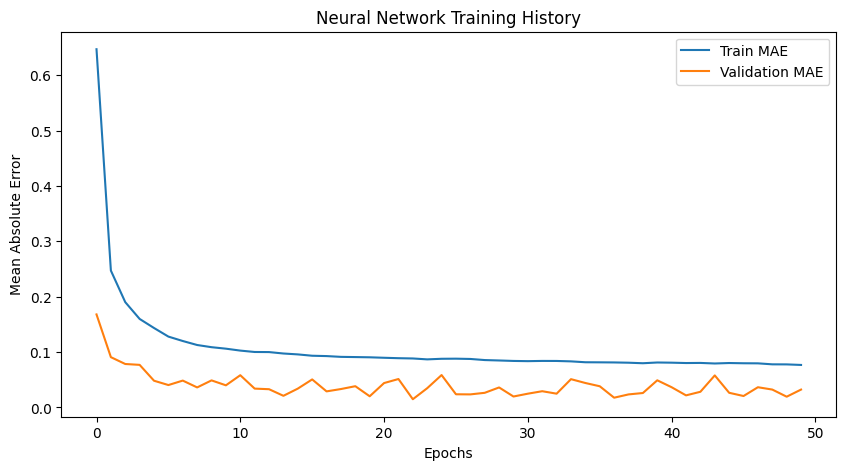

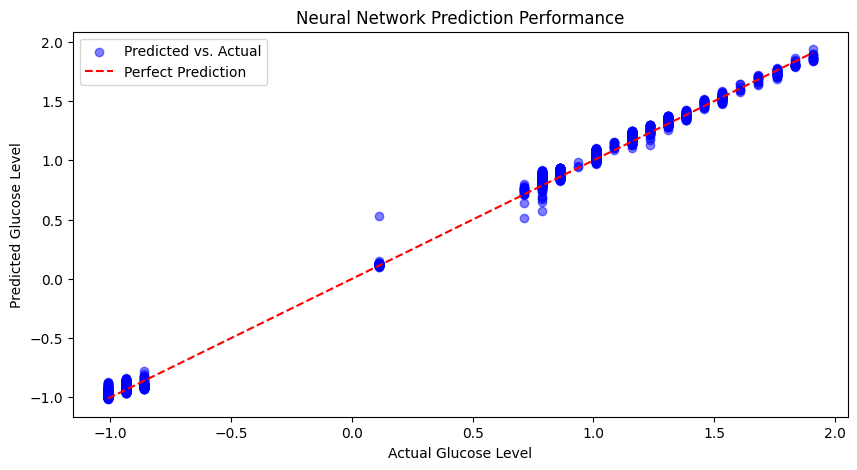

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


732/732 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.8113 - mae: 0.9667 - val_loss: 0.0180 - val_mae: 0.1011
Epoch 2/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0154 - mae: 0.0926 - val_loss: 0.0107 - val_mae: 0.0791
Epoch 3/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0089 - mae: 0.0700 - val_loss: 0.0059 - val_mae: 0.0559
Epoch 4/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0058 - mae: 0.0563 - val_loss: 0.0054 - val_mae: 0.0542
Epoch 5/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0043 - mae: 0.0481 - val_loss: 0.0034 - val_mae: 0.0410
Epoch 6/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0035 - mae: 0.0432 - val_loss: 0.0027 - val_mae: 0.0379
Epoch 7/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0034 - mae: 0.0437 - val_loss: 0.0020 - val_mae: 0.0334
Epoch 8/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0026 - mae: 0.0379 - val_loss: 0.0029 - val_mae: 0.0439
Epoch 9/50
732/732 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0023 

In [144]:
# Plot Training History
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.title("Neural Network Training History")
plt.show()

# Visualizing Predictions
plt.figure(figsize=(10, 5))
plt.scatter(y_test, nn_preds, alpha=0.5, color='blue', label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Glucose Level")
plt.ylabel("Predicted Glucose Level")
plt.legend()
plt.title("Neural Network Prediction Performance")
plt.show()

#---------------------#
nn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
nn_preds = nn_model.predict(X_test)
print("Neural Network MAE:", mean_absolute_error(y_test, nn_preds))

nn_preds = best_model.predict(X_test)
print("Optimized Neural Network MAE:", mean_absolute_error(y_test, nn_preds))
